In [2]:
import random

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from scikeras.wrappers import KerasClassifier
import keras
from keras.models import Sequential
from keras.layers import Dense

from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

plt.style.use('ggplot')

In [3]:
mlflow.login()

2024/07/15 18:21:13 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://community.cloud.databricks.com.


In [4]:
target = 'labels'
class_names = ['Blight', 'Common Rust', 'Gray Leaf Spot', 'Healthy']

In [5]:
train = pl.read_parquet('data/train_data.parquet')
val = pl.read_parquet('data/validation_data.parquet')
test = pl.read_parquet('data/test_data.parquet')

In [6]:
X_train, y_train = train.drop(target), train[target]
X_val, y_val = val.drop(target), val[target]
X_test, y_test = test.drop(target), test[target]

In [7]:
mlflow.set_experiment('/corn-disease-hybrid-ml')

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/3077886415753277', creation_time=1720696334031, experiment_id='3077886415753277', last_update_time=1721038484386, lifecycle_stage='active', name='/corn-disease-hybrid-ml', tags={'mlflow.experiment.sourceName': '/corn-disease-hybrid-ml',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'vsefareez@student.unmul.ac.id',
 'mlflow.ownerId': '3913636749821090'}>

In [8]:
# Custom cross-validation generator that only uses the training and validation sets
class PredefinedSplit:
    def __init__(self, test_fold):
        self.test_fold = test_fold

    def split(self, X, y=None, groups=None):
        train_indices = np.where(self.test_fold == -1)[0]
        test_indices = np.where(self.test_fold == 0)[0]
        yield train_indices, test_indices

    def get_n_splits(self, X, y=None, groups=None):
        return 1

In [9]:
def get_feature_importance(estimator):
    estimator.fit(X_train, y_train)
    return permutation_importance(estimator, X_val, y_val, random_state=42, n_jobs=-1)


def filter_feature(perm, X):
    # take top 5% of the important feature from df
    top_importances_subset = 0.05
    top_importances = int(X.shape[1] * top_importances_subset)
    indices = np.argsort(perm.importances_mean)[::-1][:top_importances]
    return X.select([X.columns[i] for i in indices])

In [10]:
def log_feature_selection(estimator):
    perm = get_feature_importance(estimator)
    train_filtered = filter_feature(perm, X_train)
    val_filtered = filter_feature(perm, X_val)
    test_filtered = filter_feature(perm, X_test)
    mlflow.log_params(estimator.get_params())

    train_filtered.write_parquet(f'.artifacts/{estimator.__class__.__name__}_train_filtered.parquet')
    val_filtered.write_parquet(f'.artifacts/{estimator.__class__.__name__}_val_filtered.parquet')
    test_filtered.write_parquet(f'.artifacts/{estimator.__class__.__name__}_test_filtered.parquet')

    mlflow.log_artifact(f'.artifacts/{estimator.__class__.__name__}_train_filtered.parquet',
                        'filtered_feature')
    mlflow.log_artifact(f'.artifacts/{estimator.__class__.__name__}_val_filtered.parquet', 'filtered_feature')
    mlflow.log_artifact(f'.artifacts/{estimator.__class__.__name__}_test_filtered.parquet', 'filtered_feature')
    return train_filtered, val_filtered, test_filtered

In [11]:
def log_cv_results(cv_results, estimator_name):
    cv_results_df = pl.DataFrame(cv_results, strict=False)
    param_col = [pl.col(col).map_elements(lambda x: x) for col in cv_results_df.columns if col.startswith('param_')]
    cv_results_df.select(
        pl.col('split0_test_score'),
        pl.col('rank_test_score'),
        *param_col
    ).write_csv(f'.artifacts/{estimator_name}_cv_results.csv')
    mlflow.log_artifact(f'.artifacts/{estimator_name}_cv_results.csv')

In [12]:
def evaluate_model(estimator, X_test):
    y_pred = estimator.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    confusion = confusion_matrix(y_test, y_pred, normalize='true')
    return accuracy, recall, precision, confusion

In [13]:
def log_cm(confusion):
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.size"] = 10
    fig, ax = plt.subplots(figsize=(7, 6), dpi=300)
    sns.heatmap(confusion, annot=True, fmt='.1%', cmap='Blues',
                ax=ax, annot_kws={"fontsize": 11},
                xticklabels=class_names, yticklabels=class_names)
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    mlflow.log_figure(fig, 'confusion_matrix.png')
    plt.show()
    plt.close(fig)

In [14]:
def tune_hyperparameter(estimator, param_grid, select_feature=False, name=None):
    if not name:
        name = estimator.__class__.__name__
        
    with mlflow.start_run(run_name=f'tune_{name}_{random.randint(0, 1000)}', tags={'tuning': 'true'}):
        if select_feature:
            X_train_filtered, X_val_filtered, X_test_filtered = log_feature_selection(estimator)
            mlflow.set_tag('feature_selection', 'true')
            test_fold = np.concatenate([np.full(len(X_train_filtered), -1), np.full(len(X_val_filtered), 0)])
            X_combined = np.concatenate((X_train_filtered, X_val_filtered), axis=0)
            y_combined = np.concatenate((y_train, y_val), axis=0)
            input_example = X_train_filtered.slice(0, 1)
        else:
            test_fold = np.concatenate([np.full(len(X_train), -1), np.full(len(X_val), 0)])
            X_combined = np.concatenate((X_train, X_val), axis=0)
            y_combined = np.concatenate((y_train, y_val), axis=0)
            input_example = X_train.slice(0, 1)

        random_search = RandomizedSearchCV(estimator,
                                           param_grid,
                                           scoring='accuracy',
                                           n_iter=10,
                                           n_jobs=-1,
                                           verbose=2,
                                           cv=PredefinedSplit(test_fold))
        random_search.fit(X_combined, y_combined)
        mlflow.log_params({f'best_{k}': v for k,v in random_search.best_params_.items()})
        mlflow.log_param('scoring', 'accuracy')
        mlflow.log_metric('best_score', random_search.best_score_)
        log_cv_results(random_search.cv_results_, estimator.__class__.__name__)
        mlflow.sklearn.log_model(random_search.best_estimator_, 'best_model', input_example=input_example.to_pandas())

        if select_feature:
            accuracy, recall, precision, confusion = evaluate_model(random_search.best_estimator_, X_test_filtered)
        else:
            accuracy, recall, precision, confusion = evaluate_model(random_search.best_estimator_, X_test)
        mlflow.log_metrics({
            'test_accuracy': accuracy,
            'test_recall': recall,
            'test_precision': precision})
        log_cm(confusion)
    return random_search.best_params_

In [15]:
def train_model(estimator, select_feature=False, name=None):
    if not name:
        name = estimator.__class__.__name__
        
    with mlflow.start_run(run_name=f'train_{name}_{random.randint(0, 1000)}', tags={'tuning': 'false'}):
        if select_feature:
            X_train_filtered, X_val_filtered, X_test_filtered = log_feature_selection(estimator)
            mlflow.set_tag('feature_selection', 'true')
            estimator.fit(X_train_filtered, y_train)
            input_example = X_train_filtered.slice(0, 1)
        else:
            estimator.fit(X_train, y_train)
            input_example = X_train.slice(0, 1)
            
        mlflow.log_params(estimator.get_params())
        mlflow.sklearn.log_model(estimator, 'best_model', input_example=input_example.to_pandas())

        if select_feature:
            accuracy, recall, precision, confusion = evaluate_model(estimator, X_test_filtered)
        else:
            accuracy, recall, precision, confusion = evaluate_model(estimator, X_test)
        mlflow.log_metrics({
            'test_accuracy': accuracy,
            'test_recall': recall,
            'test_precision': precision})
        log_cm(confusion)

In [16]:
def create_estimator(classifier, **kwargs):
    return classifier(**kwargs)

In [16]:
def get_model(meta, compile_kwargs):
    n_features_in = meta['n_features_in_']
    inputs = keras.Input(shape=(n_features_in,))
    x = Dense(4, activation='softmax')(inputs)
    model = keras.Model(inputs=inputs, outputs=x)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=compile_kwargs['optimizer'], metrics=['accuracy'])
    return model

D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Fitting 1 folds for each of 10 candidates, totalling 10 fits


D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
6 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 16

Uploading artifacts:   0%|          | 0/6 [00:00<?, ?it/s]

D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


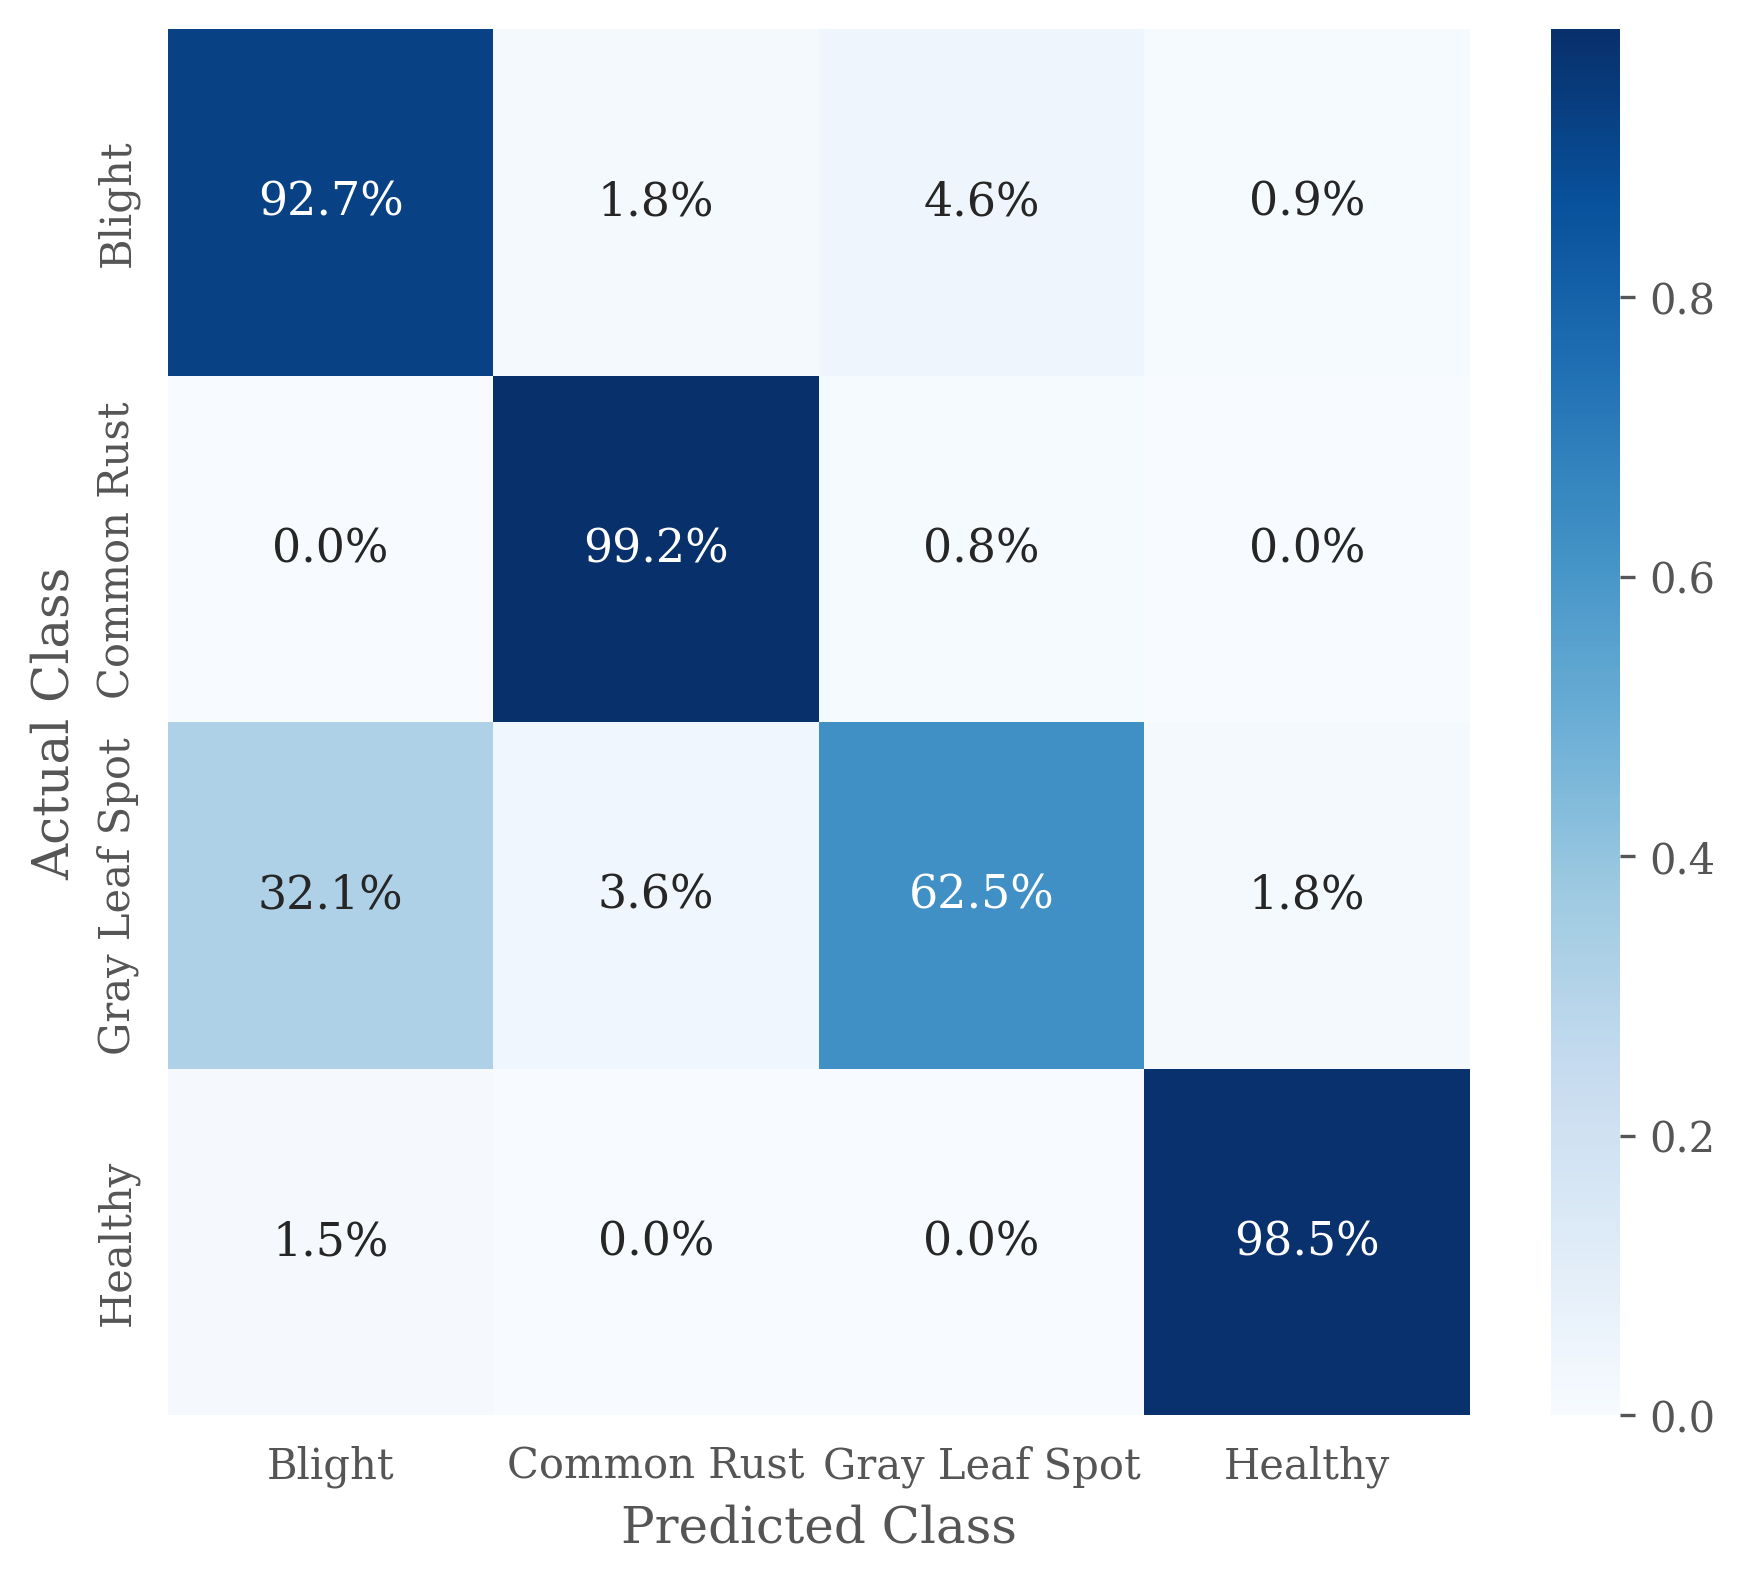

{'n_estimators': 20, 'learning_rate': 0.025, 'estimator__optimizer__learning_rate': 0.01, 'estimator__optimizer': 'adam'}


D:\Projects\corn-disease\.venv\Lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/07/15 16:09:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Uploading artifacts:   0%|          | 0/6 [00:00<?, ?it/s]

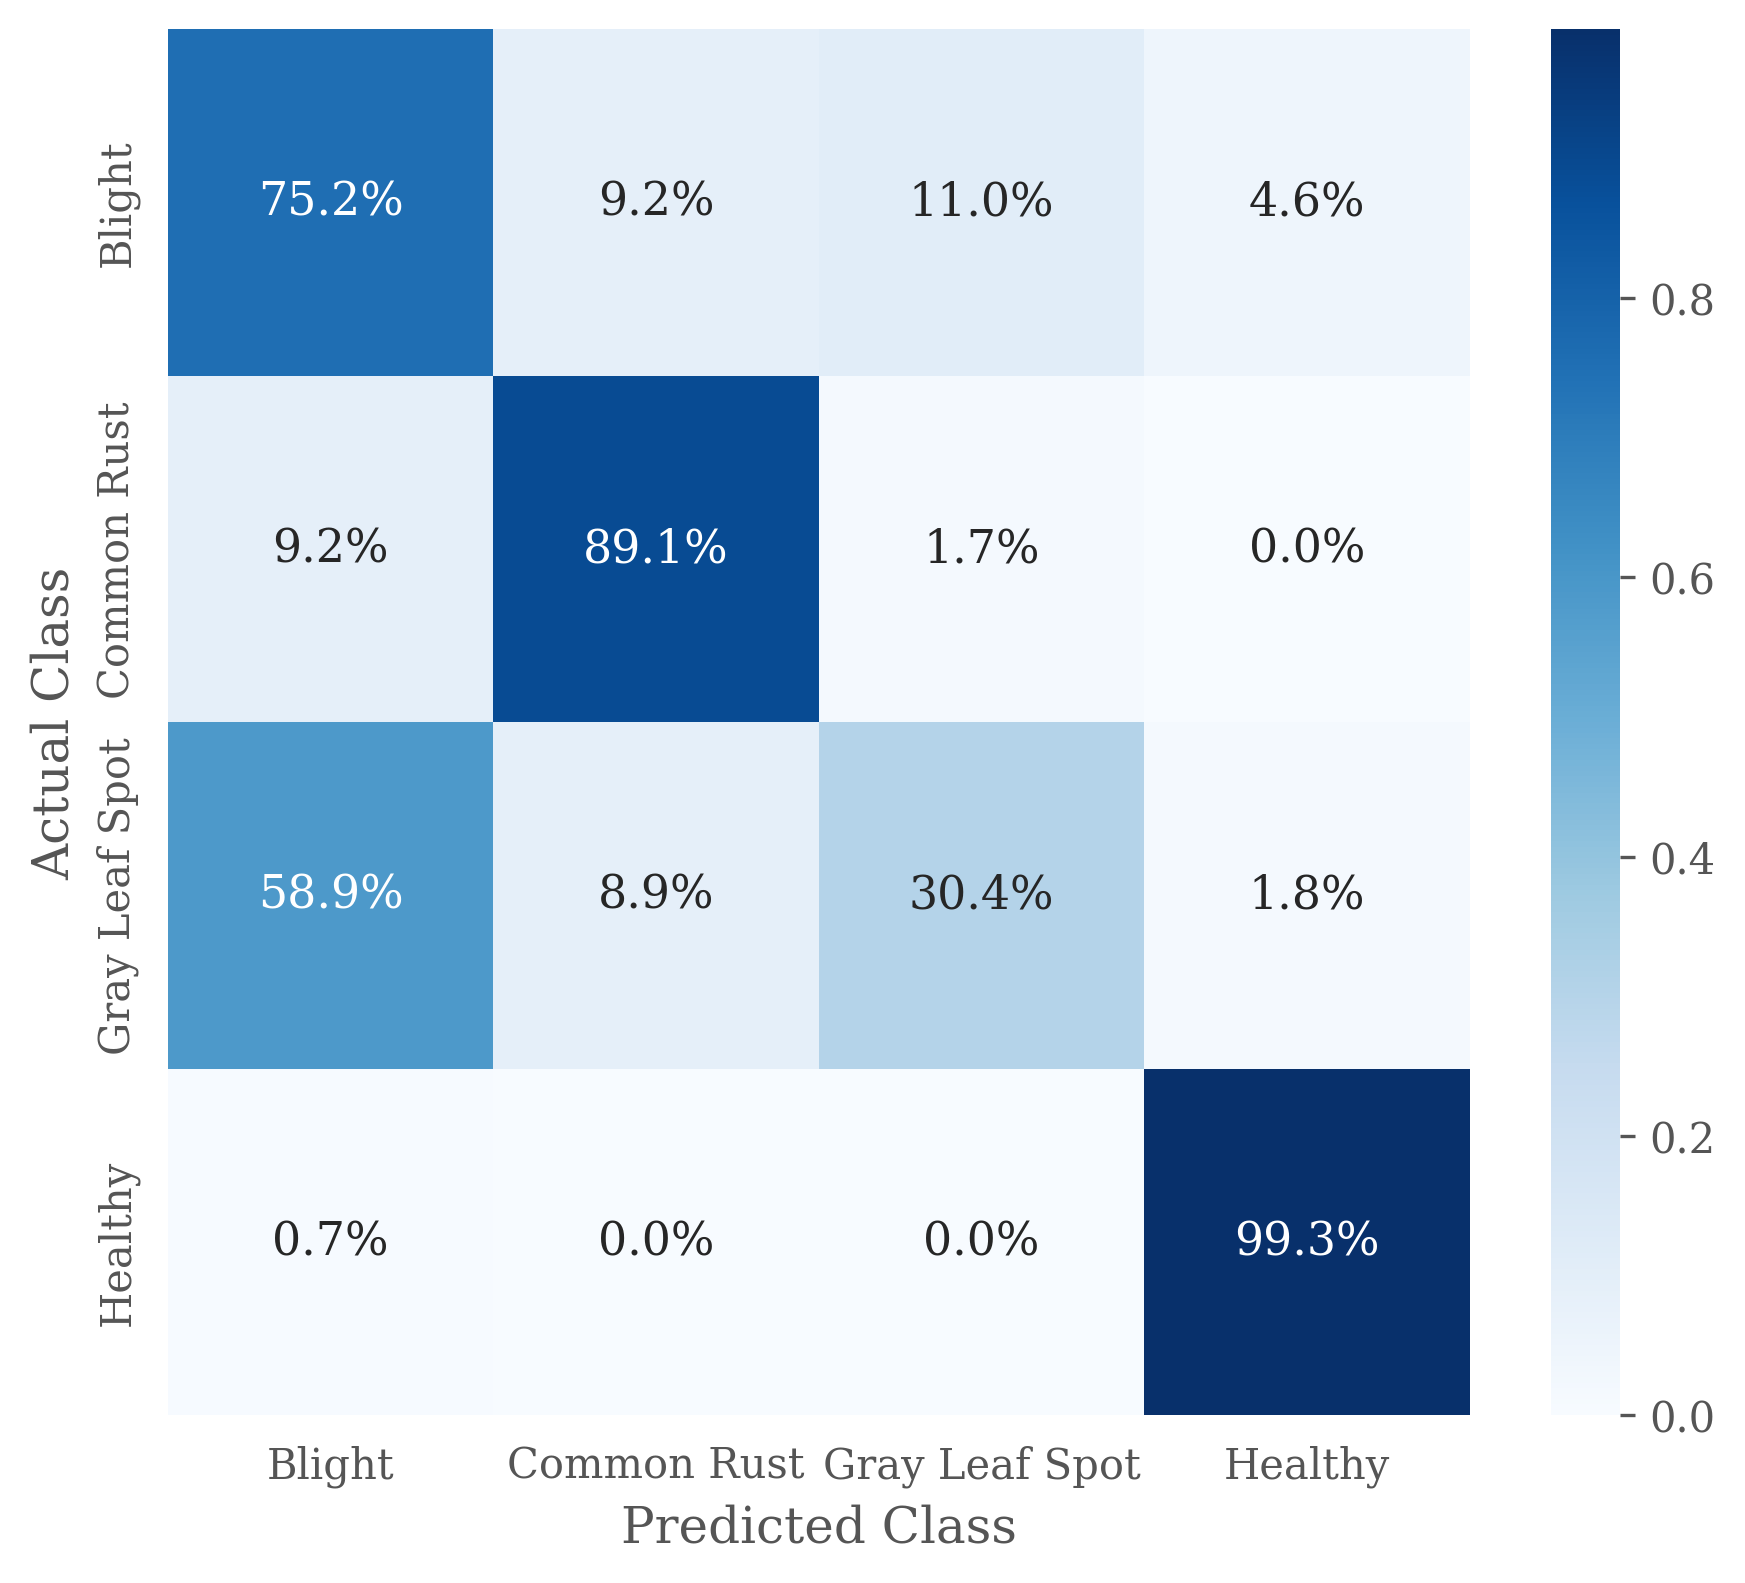

Fitting 1 folds for each of 10 candidates, totalling 10 fits


D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
4 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 16

Uploading artifacts:   0%|          | 0/6 [00:00<?, ?it/s]

2024/07/15 16:28:51 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under dbfs:/databricks/mlflow-tracking/3077886415753277/4b041fa73b744b918fdd04cdcc75f03a/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


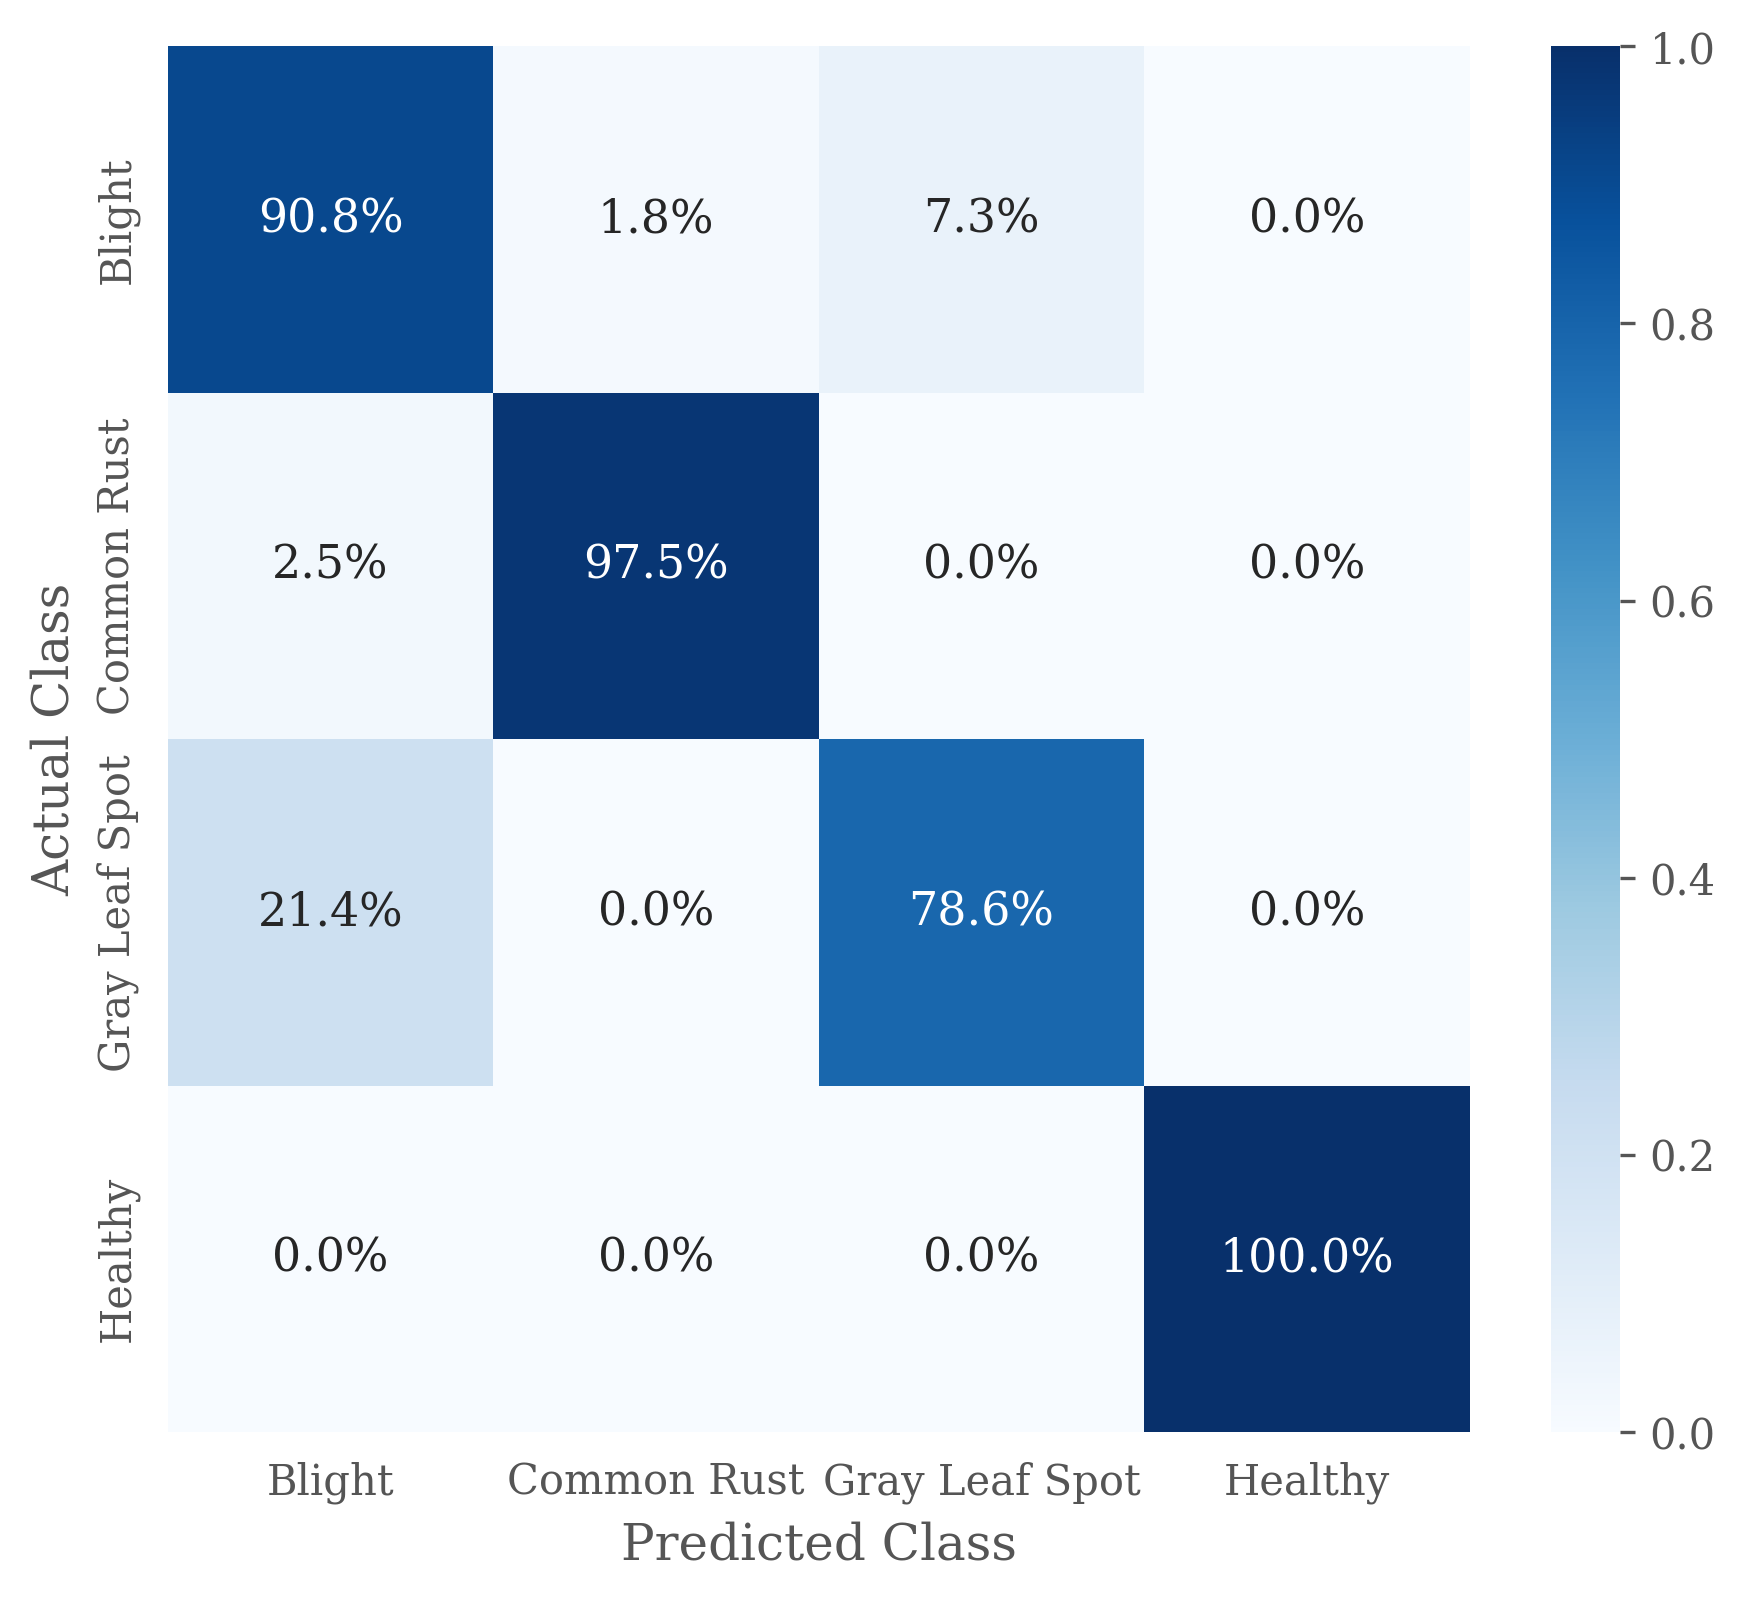

{'n_estimators': 100, 'learning_rate': 0.1, 'estimator__optimizer__learning_rate': 0.001, 'estimator__optimizer': 'adam'}


D:\Projects\corn-disease\.venv\Lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/07/15 16:29:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Uploading artifacts:   0%|          | 0/6 [00:00<?, ?it/s]

2024/07/15 16:29:30 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under dbfs:/databricks/mlflow-tracking/3077886415753277/51c2fe413cde4439943376894c9b0d1f/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


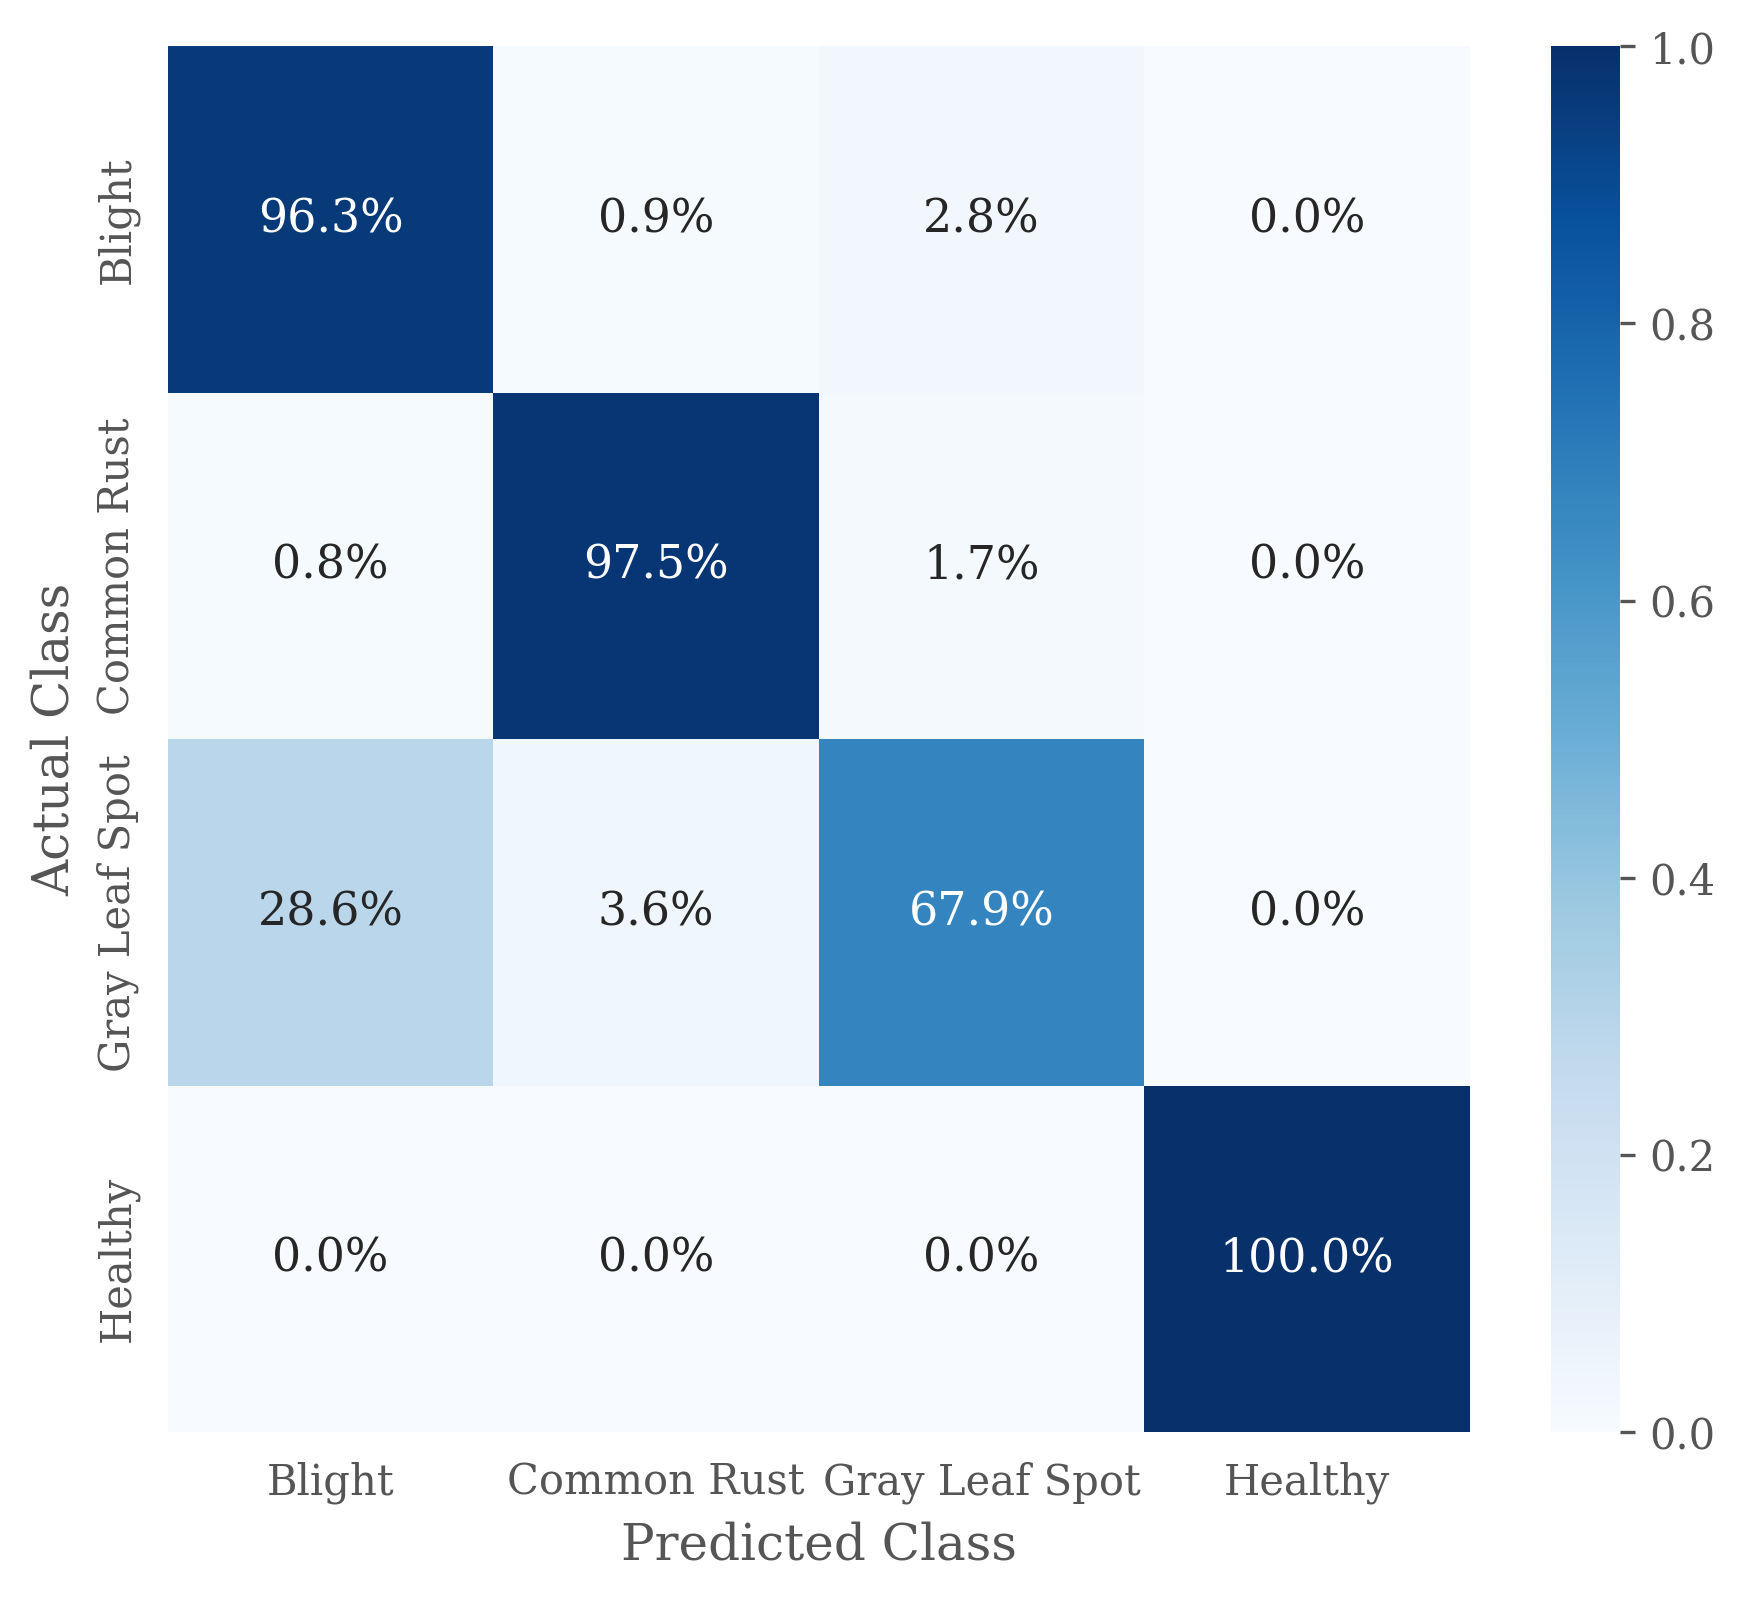

In [17]:
for fs in [True, False]:
    # with hyperparameter tuning
    best_param = tune_hyperparameter(
        create_estimator(
            AdaBoostClassifier,
            estimator=KerasClassifier(model=get_model, epochs=25, random_state=42, verbose=0, optimizer='adam', optimizer__learning_rate=0.0001),
            algorithm='SAMME',
            random_state=42
        ),
        {
            'n_estimators': [20, 100, 500, 50],
            'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.4, 1],
            'estimator__optimizer__learning_rate': [0.0001, 0.001, 0.01],
            'estimator__optimizer': ['adam', 'sgd'],
        },
        select_feature=fs,
        name='BoostedKerasClassifier'
    )
    print(best_param)
    # without hyperparameter tuning
    train_model(
        create_estimator(KerasClassifier, model=get_model, epochs=25, random_state=42, verbose=0, optimizer='adam', optimizer__learning_rate=0.0001),
        select_feature=fs
    )


D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Fitting 1 folds for each of 10 candidates, totalling 10 fits


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
D:\Projects\corn-disease\.venv\Lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema cont

Uploading artifacts:   0%|          | 0/6 [00:00<?, ?it/s]

D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


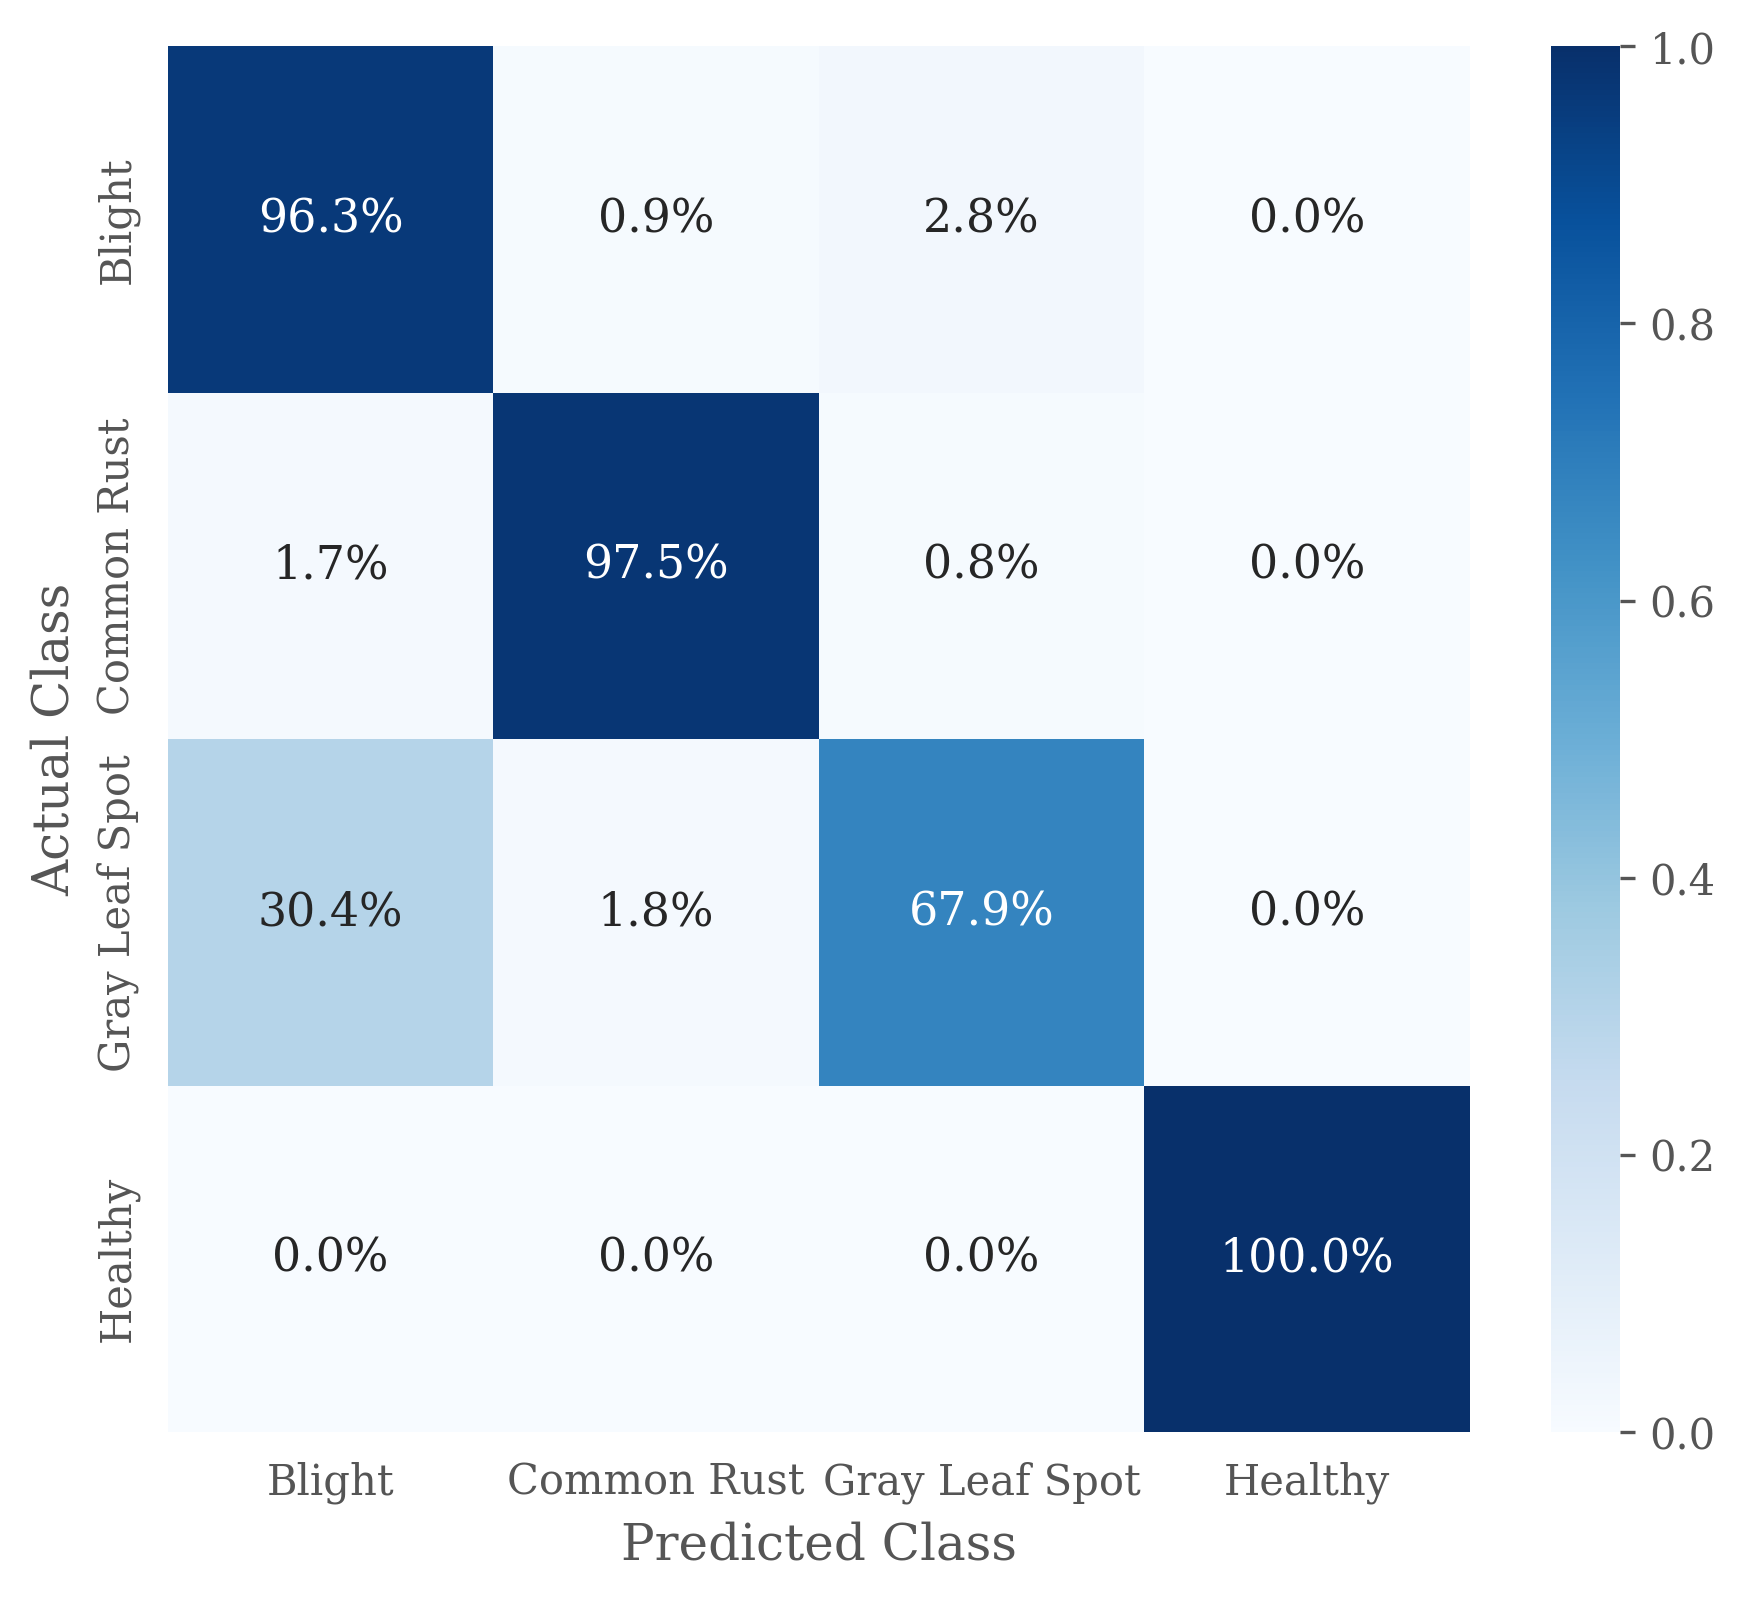

Fitting 1 folds for each of 10 candidates, totalling 10 fits


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
D:\Projects\corn-disease\.venv\Lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema cont

Uploading artifacts:   0%|          | 0/6 [00:00<?, ?it/s]

2024/07/15 18:09:32 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under dbfs:/databricks/mlflow-tracking/3077886415753277/29da41a45af04fd2aa3075f4213dc581/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


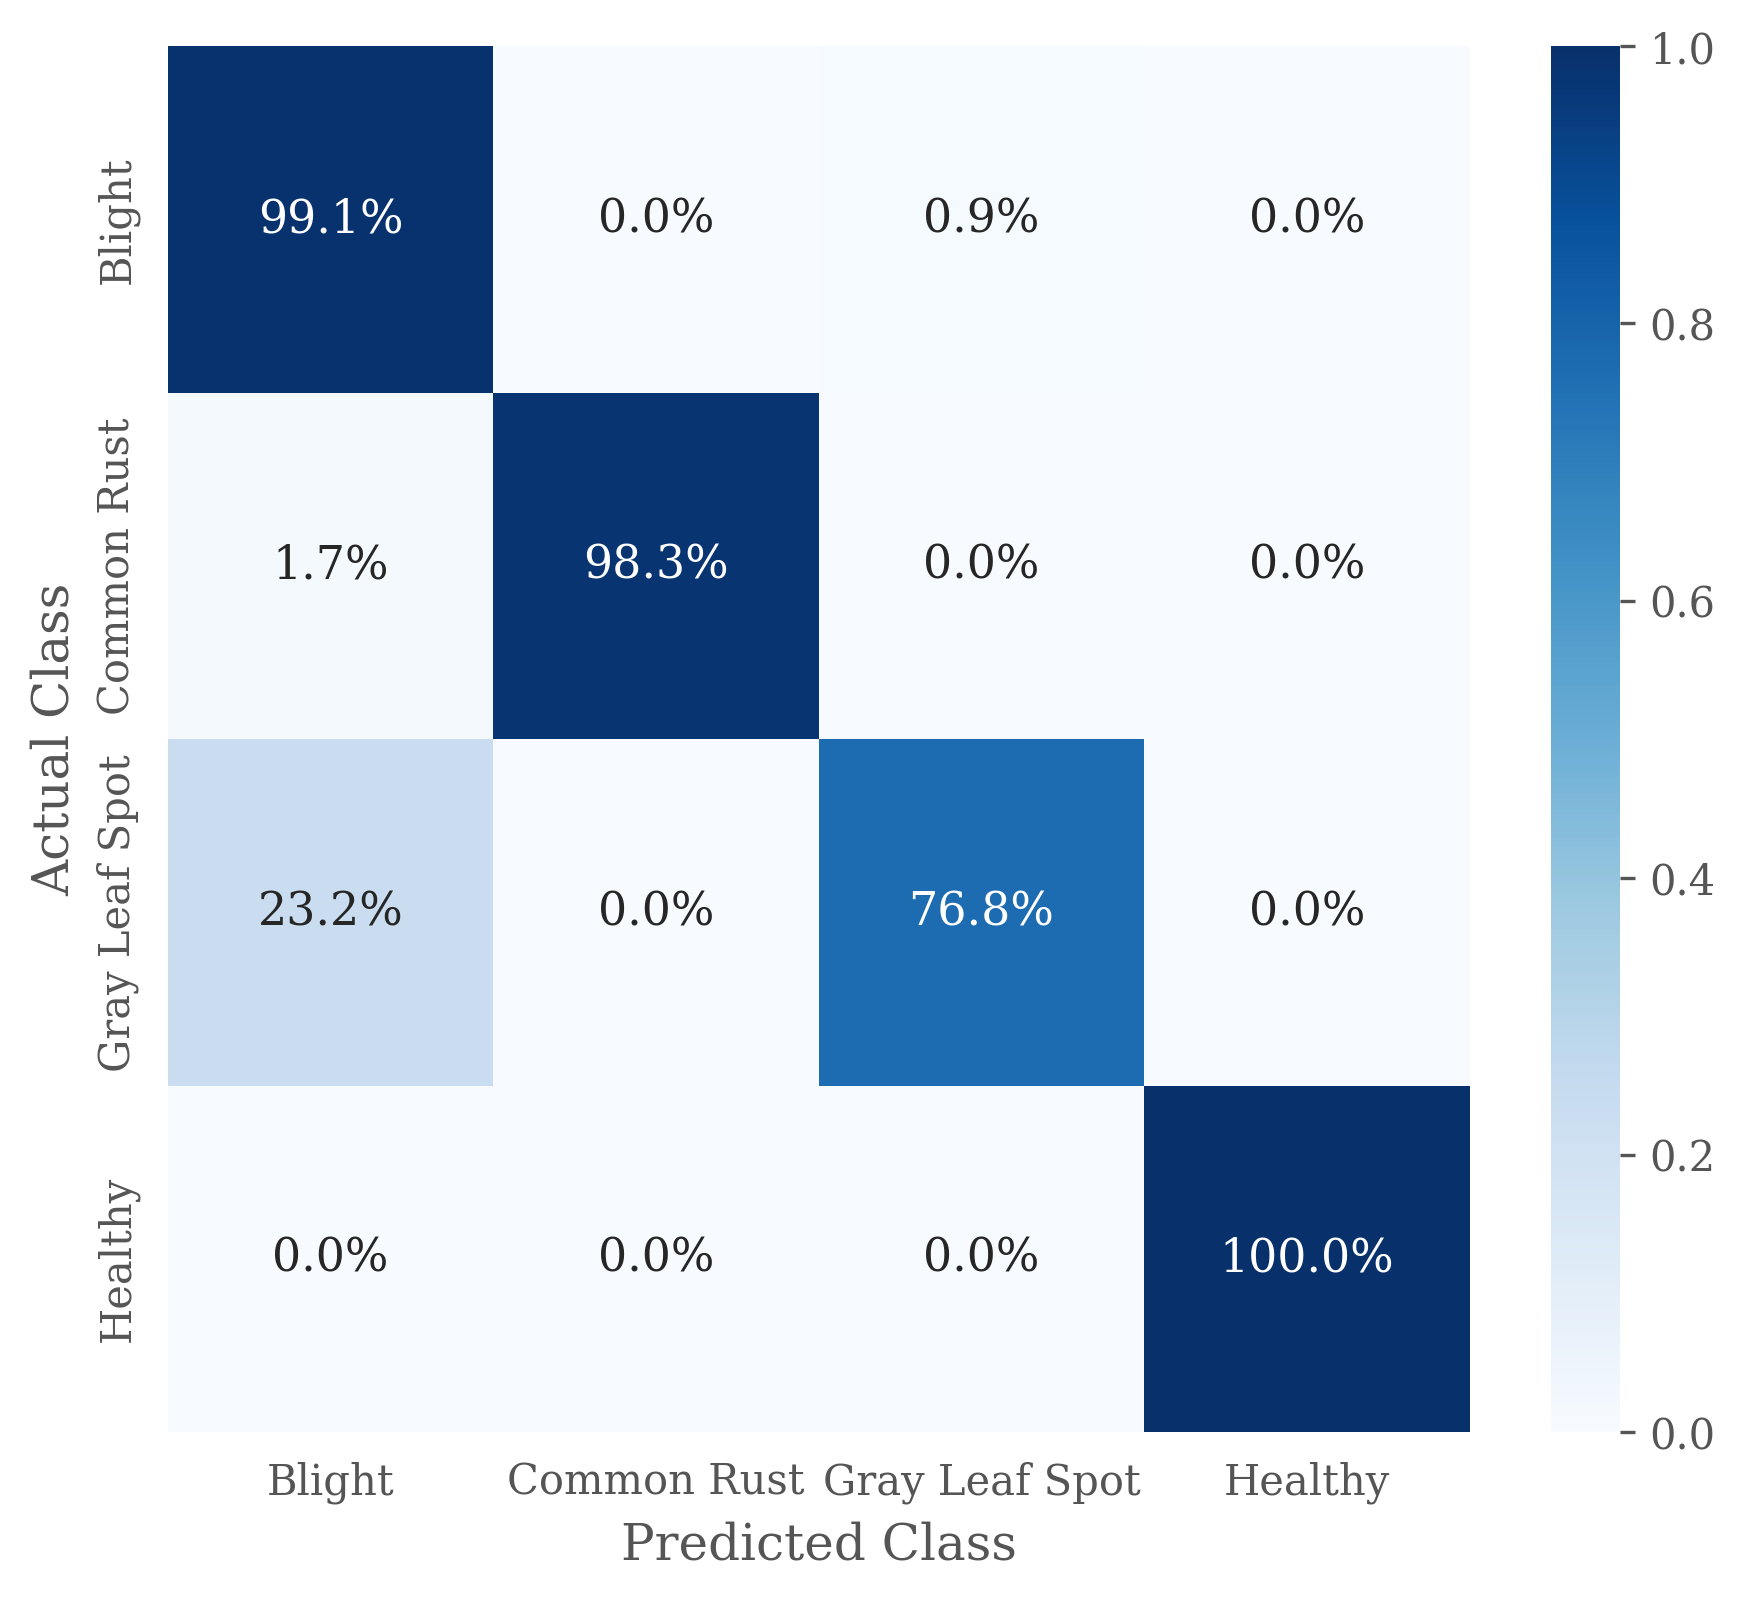

In [19]:
for fs in [True, False]:
    # with hyperparameter tuning
    _ = tune_hyperparameter(
        create_estimator(
            AdaBoostClassifier,
            estimator=DecisionTreeClassifier(random_state=42),
            algorithm='SAMME',
            random_state=42
        ),
        {
            'n_estimators': [20, 100, 500, 50],
            'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.4, 1],
            'estimator__min_samples_leaf': [1, 10, 50],
            'estimator__max_leaf_nodes': [2, 8, 32, 128, None]
        },
        select_feature=fs
    )

In [17]:
for fs in [True, False]:
    # with hyperparameter tuning
    _ = tune_hyperparameter(
        create_estimator(RandomForestClassifier, random_state=42),
        {
            'max_depth': [1, 16, 64, None],
            'n_estimators': [1, 8, 32, 100],
            'min_samples_leaf': [1, 4, 16],
        },
        select_feature=fs
    )

KeyboardInterrupt: 

D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Fitting 1 folds for each of 10 candidates, totalling 10 fits


D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable result

Uploading artifacts:   0%|          | 0/6 [00:00<?, ?it/s]

D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


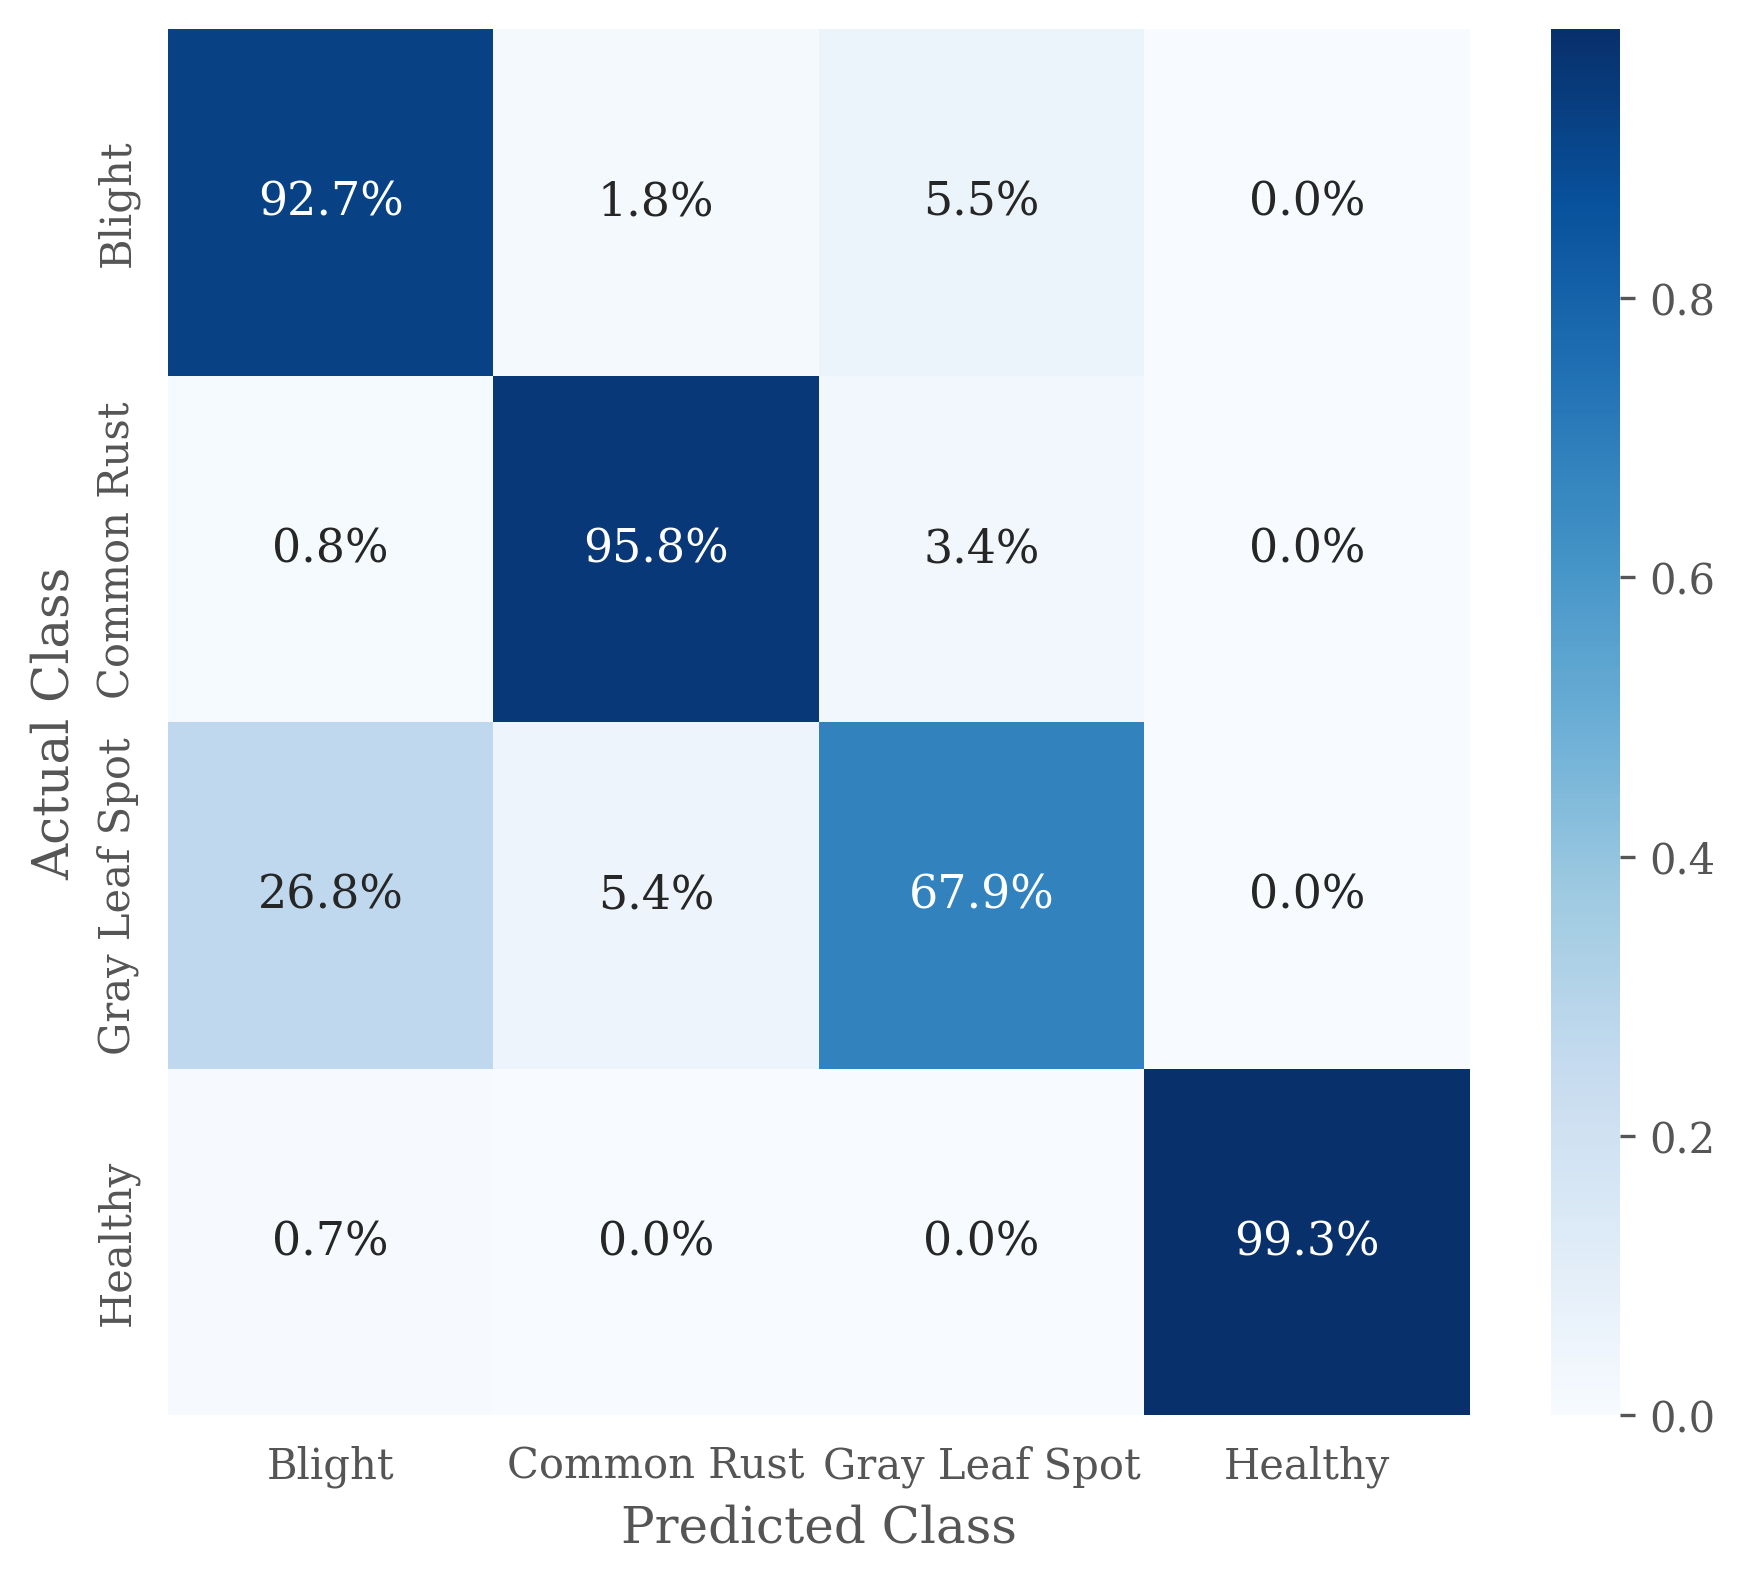

Fitting 1 folds for each of 10 candidates, totalling 10 fits


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
D:\Projects\corn-disease\.venv\Lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and

Uploading artifacts:   0%|          | 0/6 [00:00<?, ?it/s]

2024/07/15 18:23:19 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under dbfs:/databricks/mlflow-tracking/3077886415753277/dcb505512deb40dd9c59d4f26fe39156/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


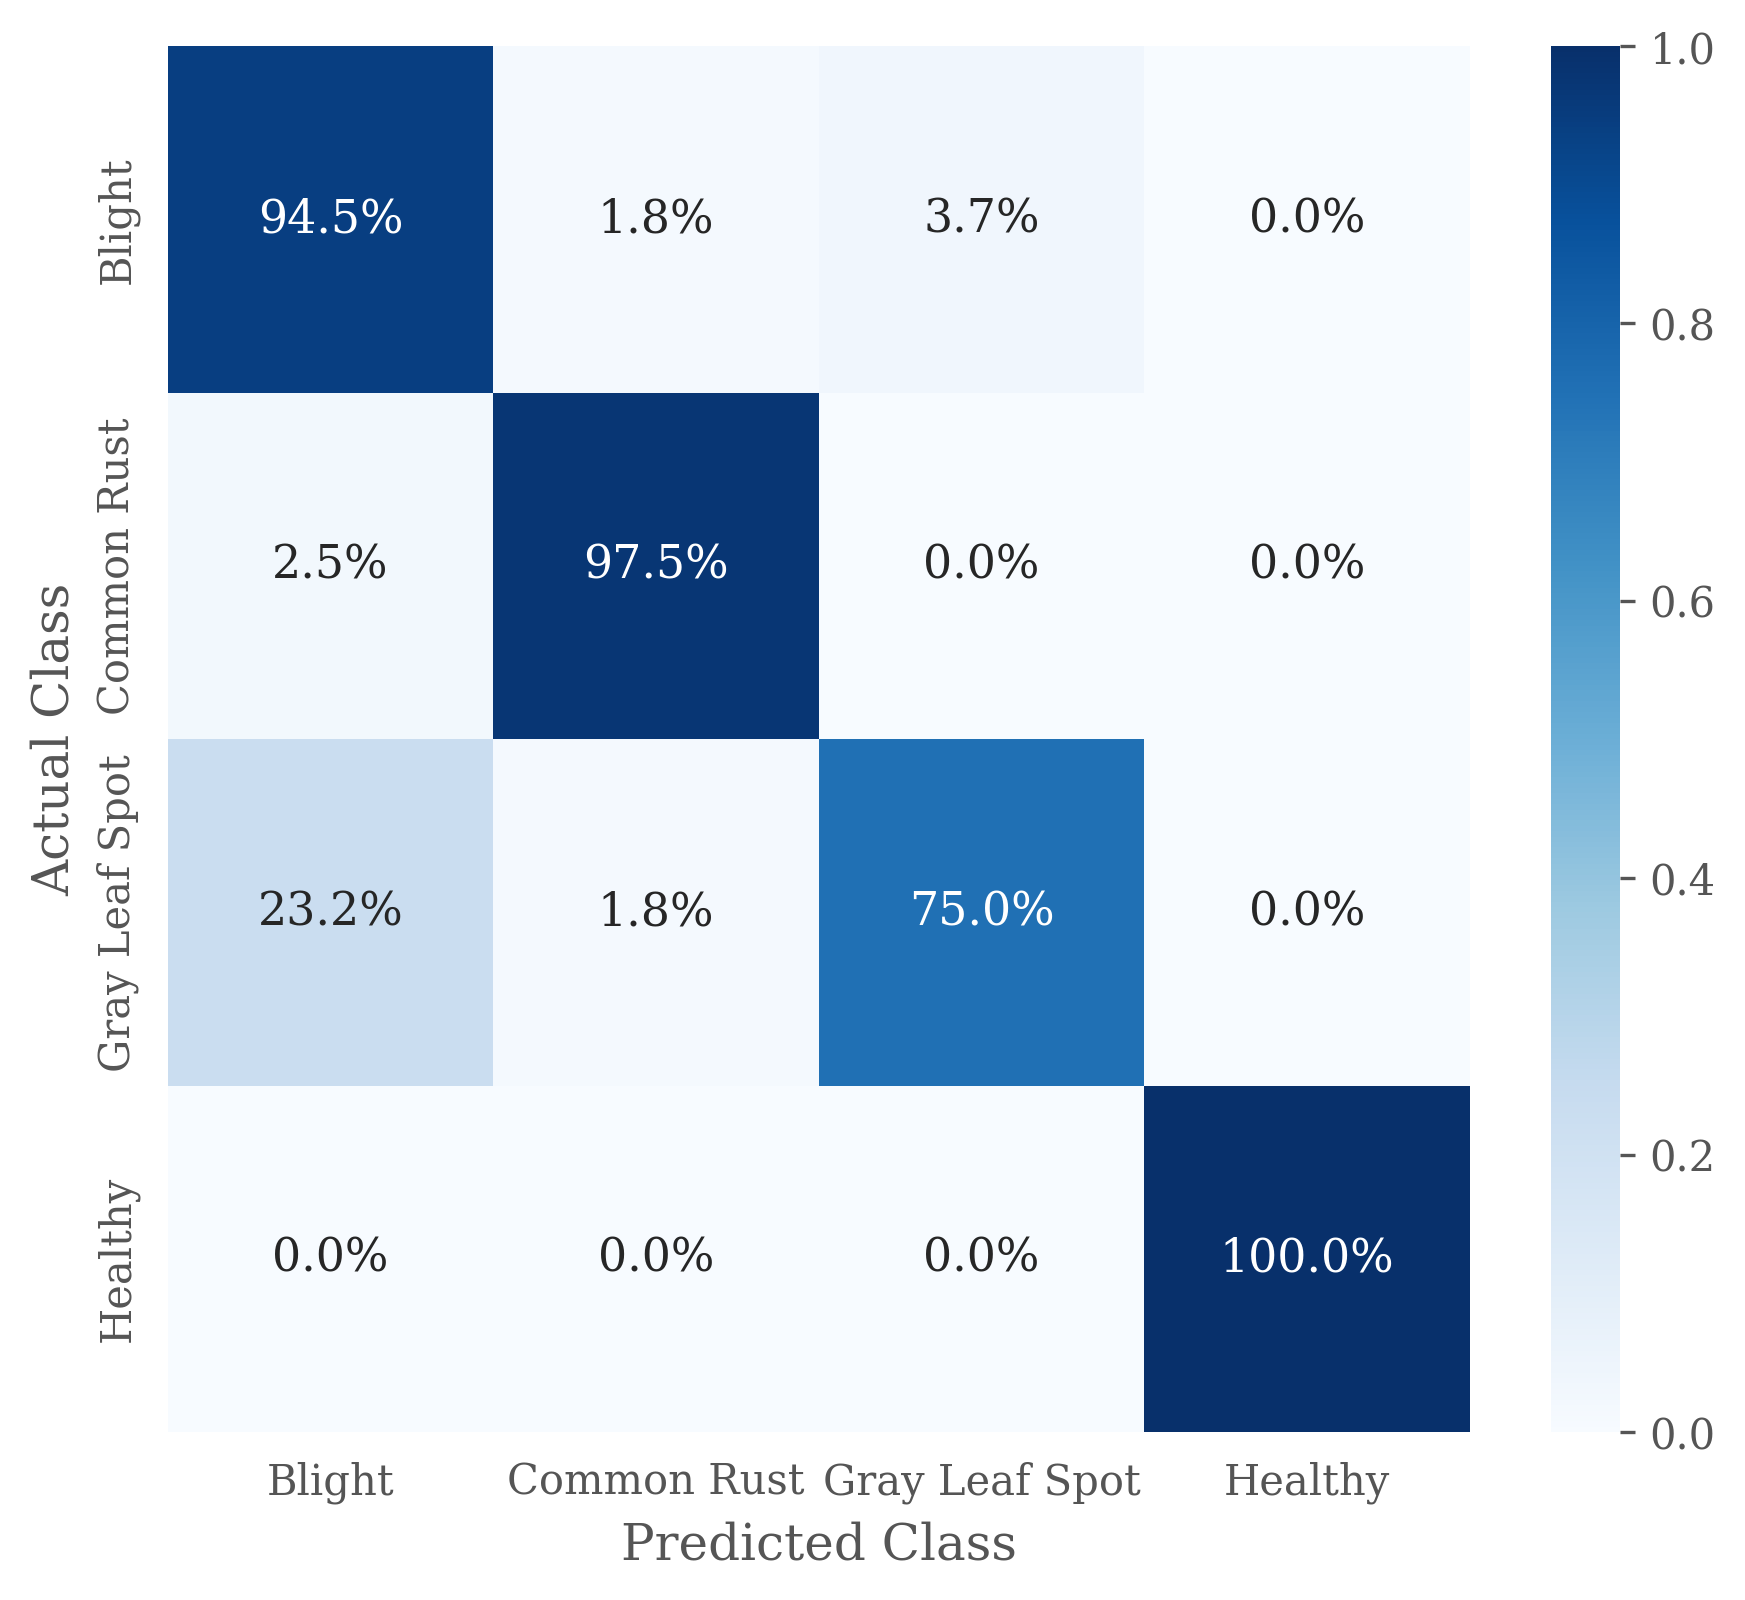

In [18]:
for fs in [True, False]:
    tune_hyperparameter(
        create_estimator(LogisticRegression, random_state=42),
        {
            'tol': [1e-5, 1e-8, 1e-4],
            'C': [0.01, 0.1, 1],
            'max_iter': [100, 1000, 2000, 3000]
        },
        select_feature=fs,
    )

In [ ]:
for fs in [True, False]:
    tune_hyperparameter(
        create_estimator(AdaBoostClassifier, estimator=LogisticRegression(random_state=42), algorithm='SAMME', random_state=42),
        {
            'n_estimators': [20, 100, 500, 50],
            'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.4, 1],
            'estimator__tol': [1e-5, 1e-8, 1e-4],
            'estimator__C': [0.01, 0.1, 1],
            'estimator__max_iter': [1000, 2000, 3000]
        },
        select_feature=fs,
        name='BoostedLogisticRegression'
    )

D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Fitting 1 folds for each of 10 candidates, totalling 10 fits


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
D:\Projects\corn-disease\.venv\Lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a s

Uploading artifacts:   0%|          | 0/6 [00:00<?, ?it/s]

D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


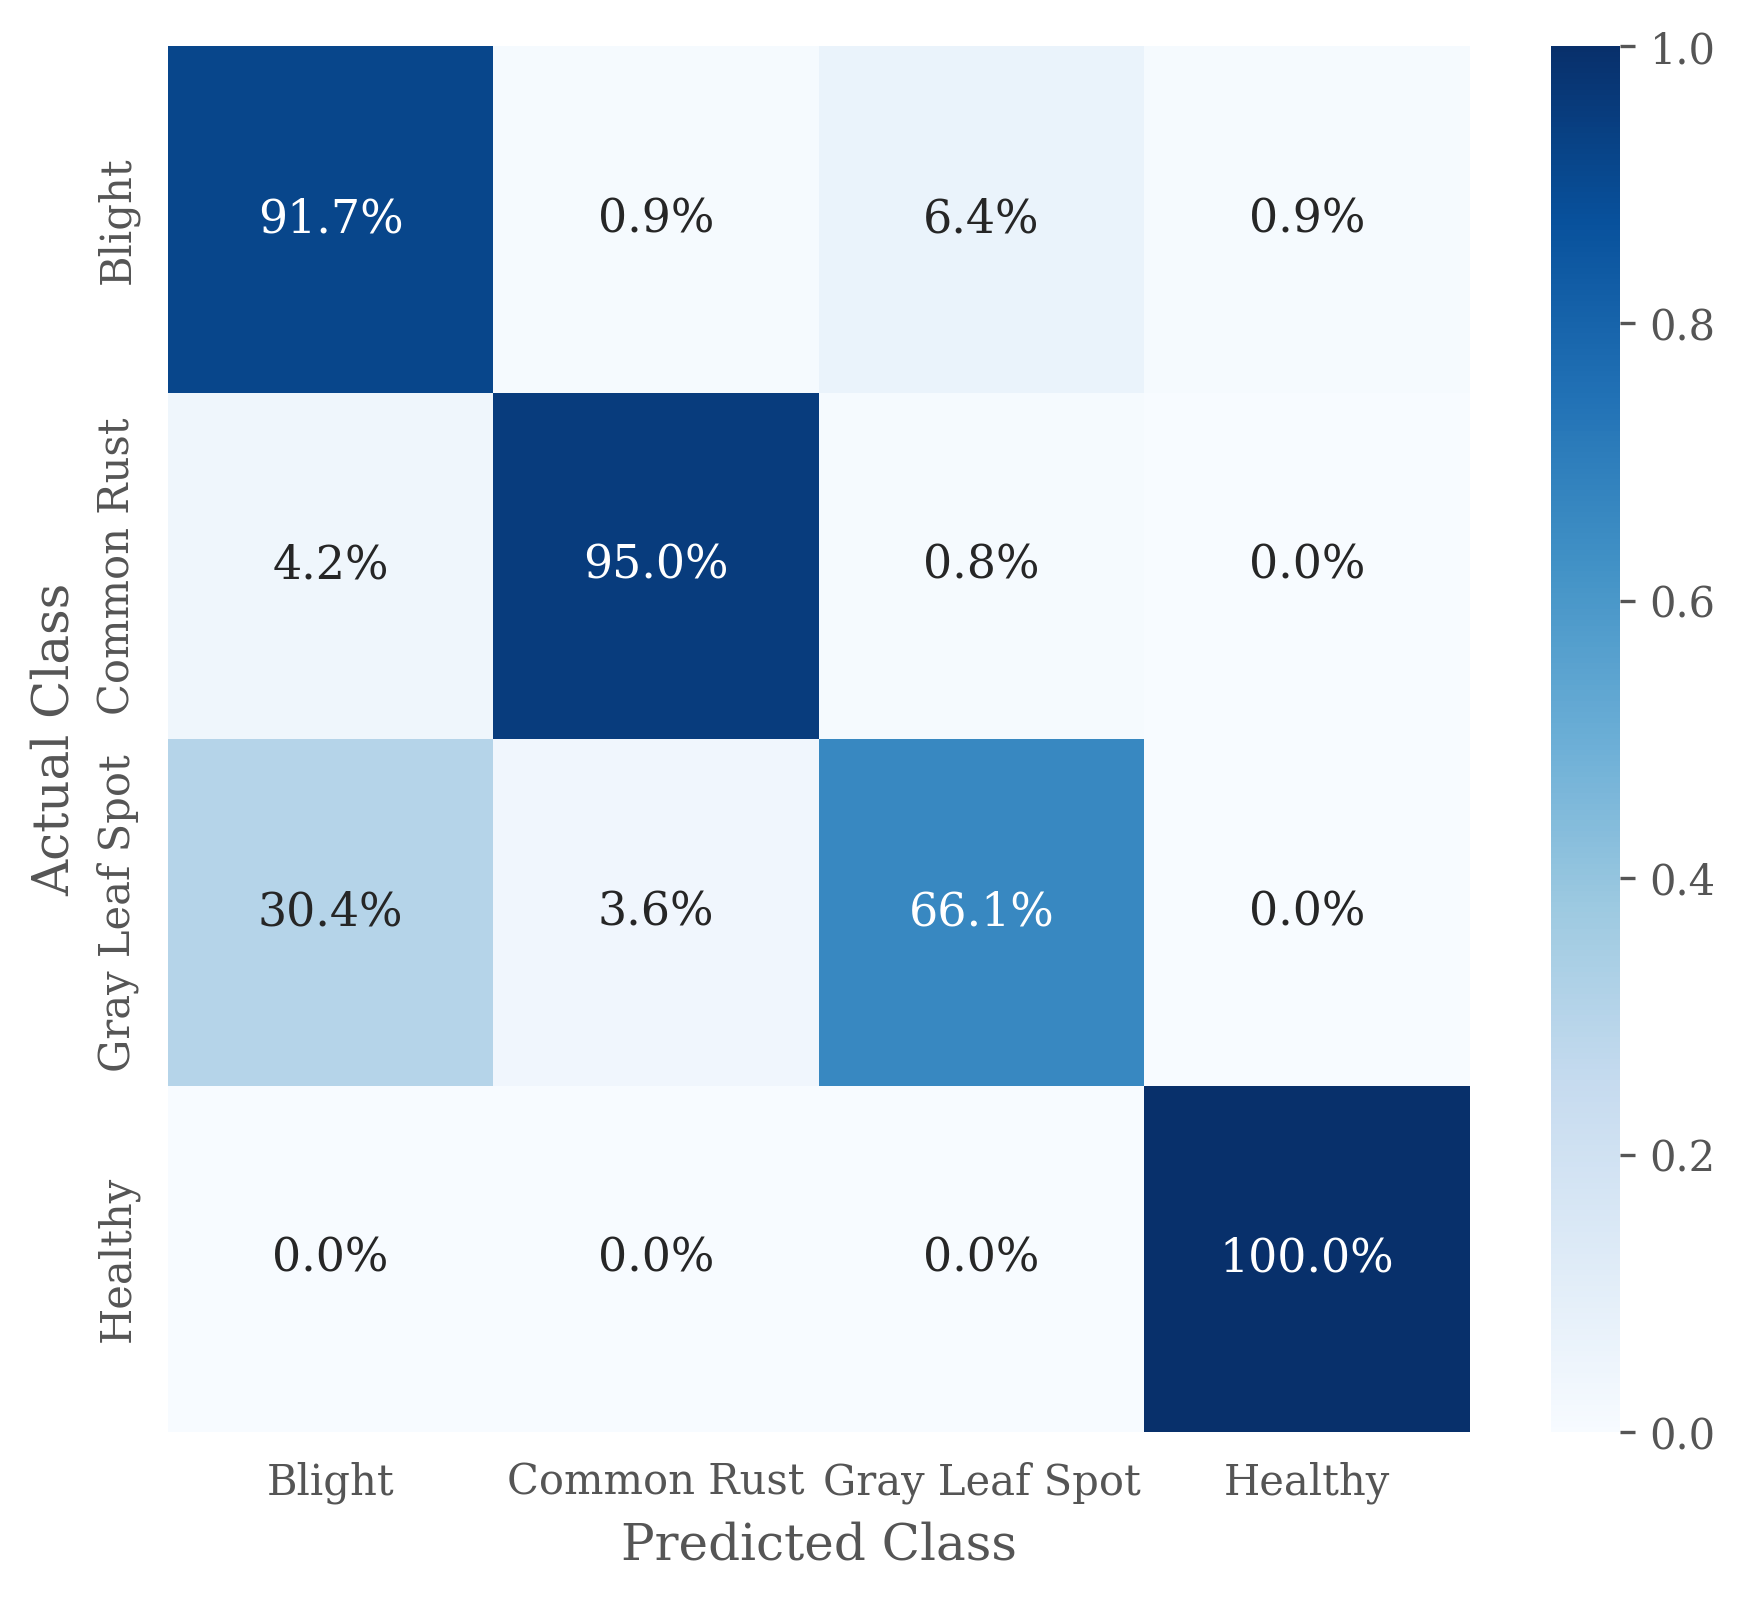

Fitting 1 folds for each of 10 candidates, totalling 10 fits


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
D:\Projects\corn-disease\.venv\Lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a s

Uploading artifacts:   0%|          | 0/6 [00:00<?, ?it/s]

2024/07/15 18:29:05 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under dbfs:/databricks/mlflow-tracking/3077886415753277/ffa57dffb46b4c24b3408d9d679078e7/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


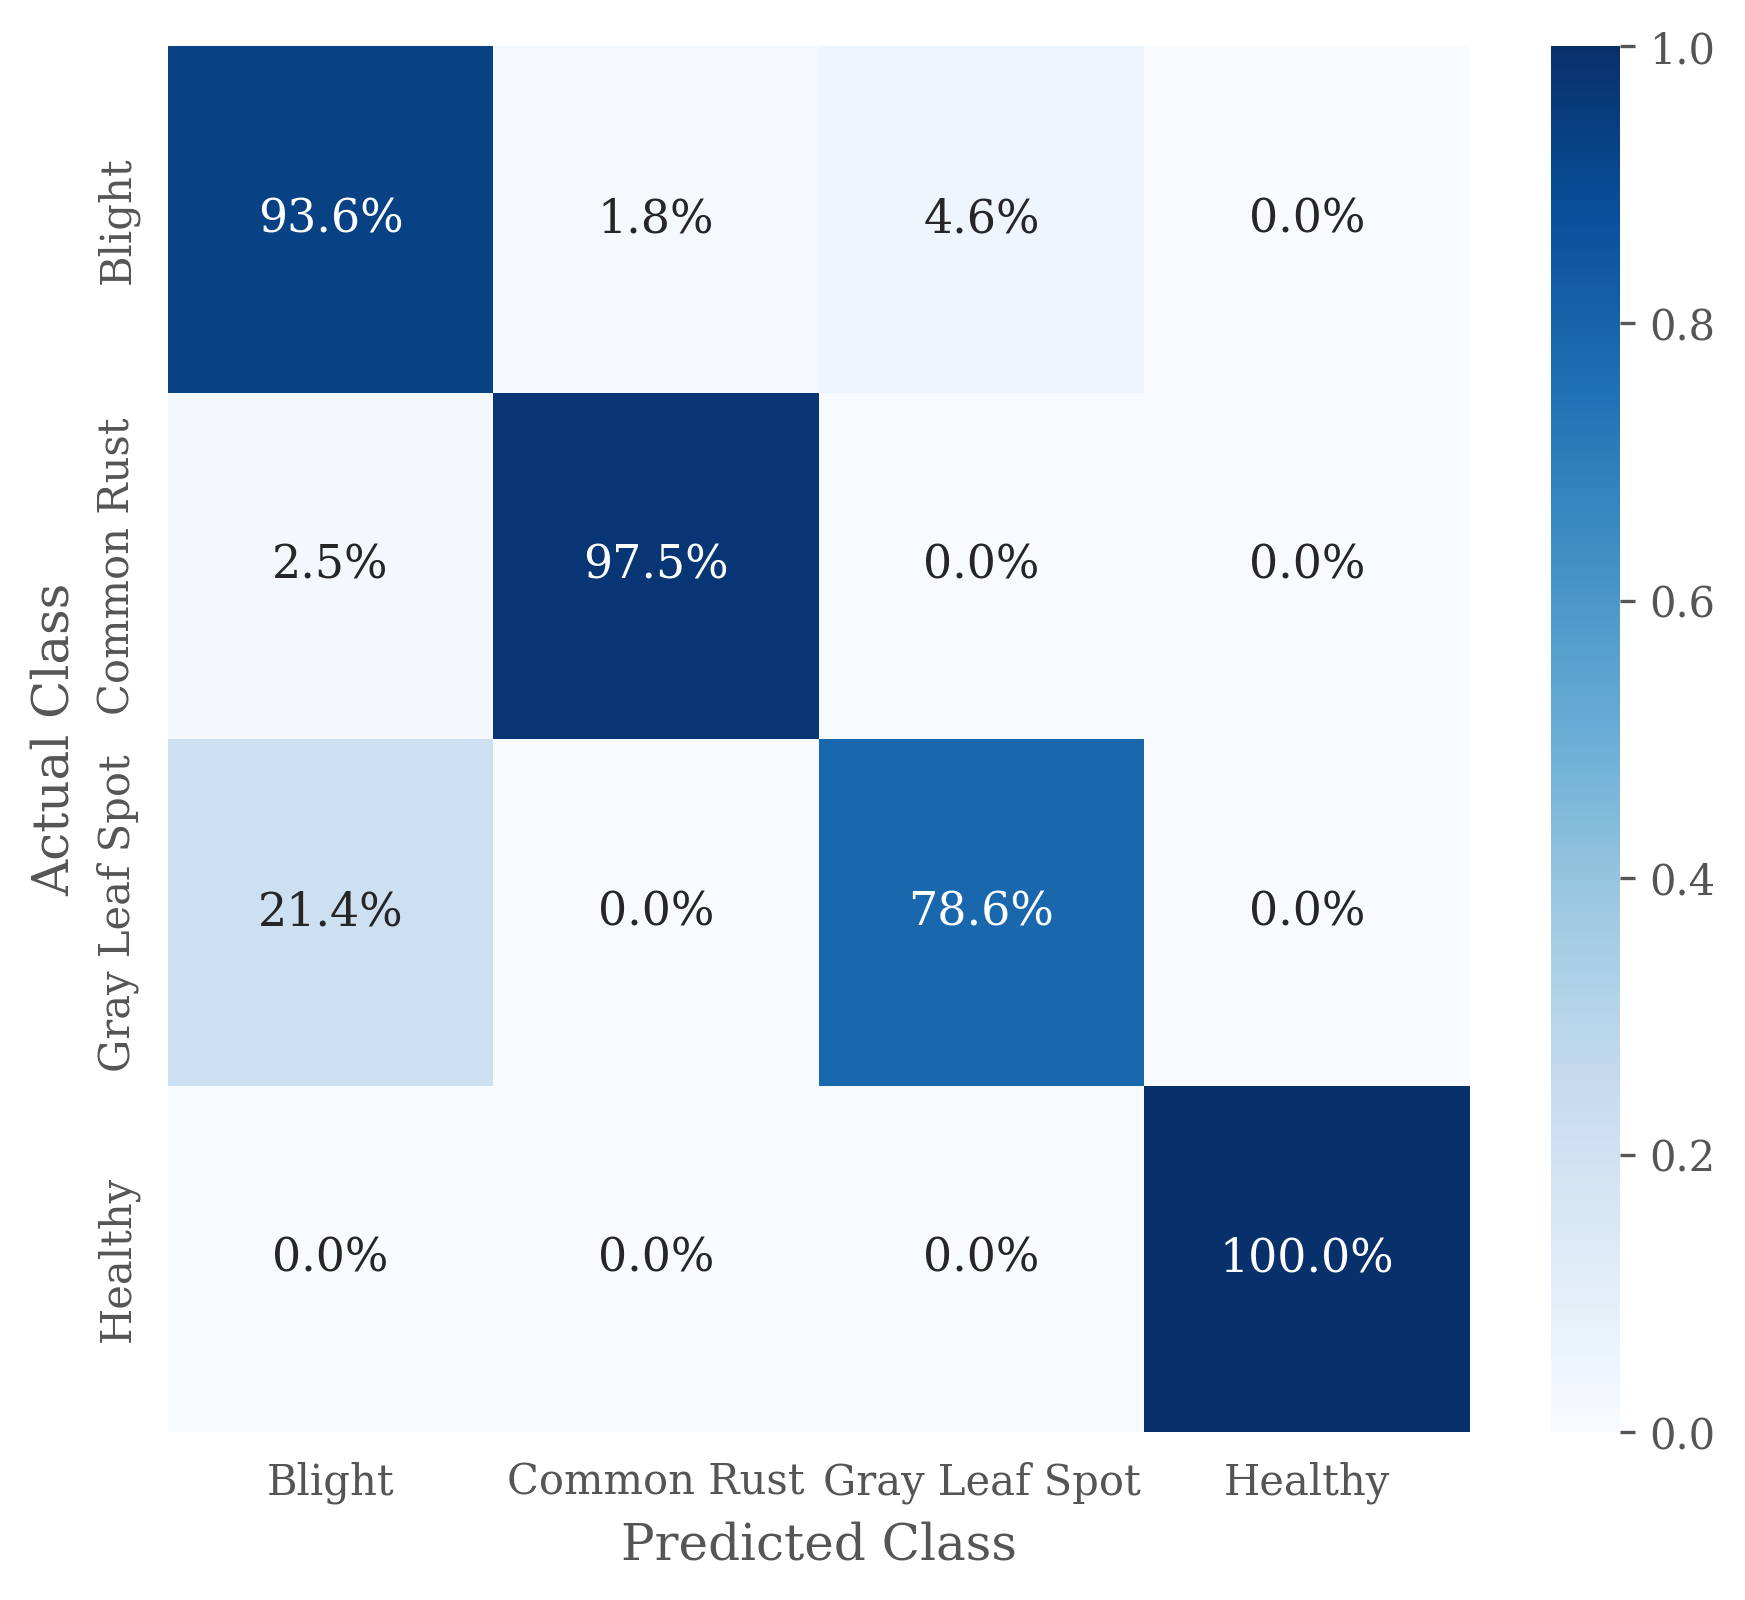

In [19]:
for fs in [True, False]:
    # with hyperparameter tuning
    tune_hyperparameter(
        create_estimator(SVC, random_state=42),
        {
            'C': [1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto'],
        },
        select_feature=fs,
    )

In [ ]:
for fs in [True, False]:
    # with hyperparameter tuning
    tune_hyperparameter(
        create_estimator(AdaBoostClassifier, estimator=SVC(random_state=42), algorithm='SAMME', random_state=42),
        {
            'n_estimators': [20, 100, 500, 50],
            'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.4, 1],
            'estimator__C': [1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 10],
            'estimator__kernel': ['linear', 'rbf'],
            'estimator__gamma': ['scale', 'auto'],
        },
        select_feature=fs,
        name='BoostedSVC'
    )